### Clustering for Shape Image Data (Square and Circle) from 3 Different Frequencies 

In [1]:
from ReadData import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans

Read in the square and circle images 

In [2]:
def readData(path, getTargetName = False):
    # print(getTargetName)
    data = getEMData(path)
    target = []
    field = []
    freq = []
    if getTargetName:
        targetName = []
        upper_case = [char for char in path if char.isupper()]
        target_name = path[path.index(upper_case[0]):path.index(upper_case[1])]

    for i in range(0, len(data)):
        target.append(data[i].target)
        field.append(data[i].Esct.real)
        freq.append(data[i].freq)
        if getTargetName: targetName.append(target_name)

    field = np.array(field)
    target = np.array(target)
    freq = np.array(freq)
    if getTargetName: targetName = np.array(targetName)

    result = (field, target, freq)
    if getTargetName: result = (field, target, freq, targetName)
    return result

In [3]:
fieldCirc, targetCirc, freqCirc, shapeCirc = readData(path = "./CircDifFreq/", getTargetName=True)

Read 240 samples


In [4]:
fieldSqr, targetSqr, freqSqr, shapeSqr = readData("./SqrDifFreq/", True)

Read 240 samples


In [5]:
np.unique(shapeCirc)
# shapeCirc[1]

array(['Circ'], dtype='<U4')

In [6]:
[fieldCirc.shape, fieldSqr.shape]

[(240, 24, 24), (240, 24, 24)]

In [7]:
[targetCirc.shape, targetSqr.shape]

[(240, 50, 50), (240, 50, 50)]

Combine the field image, target image and frequency of theses 2 shapes 

In [8]:
fieldCS = np.concatenate((fieldCirc, fieldSqr))
targetCS = np.concatenate((targetCirc, targetSqr))
freqCS = np.concatenate((freqCirc, freqSqr))
shapeCS = np.concatenate((shapeCirc,shapeSqr))

In [9]:
field_train_CS, field_test_CS, target_train_CS, target_test_CS, freq_train_CS, freq_test_CS, shape_train_CS, shape_test_CS = train_test_split(
    fieldCS, targetCS, freqCS, shapeCS, test_size=0.20, random_state=42)

In [10]:
field_test = field_test_CS.reshape(len(field_test_CS),-1)

field_train = field_train_CS.reshape(len(field_train_CS),-1)

[field_test.shape, field_train.shape]

[(96, 576), (384, 576)]

Create MiniBatchKMeans model

In [11]:
def getKmeans(num_clusters, train_data):
    # Initialize the K-Means model
    kmeans = MiniBatchKMeans(n_clusters = num_clusters, random_state = 420)
    # Fitting the model to training set
    kmeans.fit(train_data)
    return kmeans

Try with 3 clusters corresponding to 3 frequencies to see if clustering groups by frequency

In [12]:
total_clusters = 3
kmeans3 = getKmeans(total_clusters, field_train)

In [13]:
centroids3 = kmeans3.cluster_centers_.reshape(total_clusters,24,24)
centroids3.shape

(3, 24, 24)

Plot the centroids for the clusters

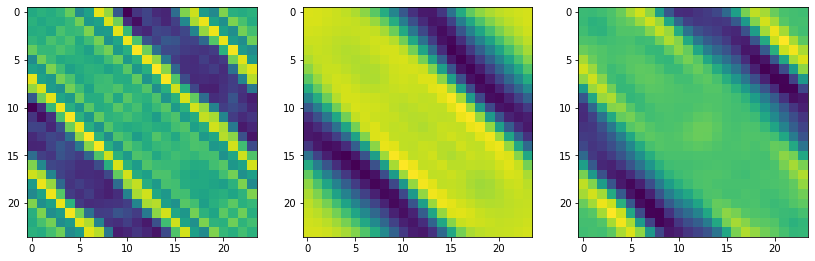

In [14]:
plt.figure(figsize = (14,14))
for index, img in enumerate(centroids3):
    plt.subplot(1,len(centroids3),index+1)
    plt.imshow(img)
    # plt.axis('off')

In [15]:
def getClusters(KMeans, field, freq, target, shape, printFreq = False, printAvgFreq = False, targetShape = False, printShape = False):
    clustered_images = {}
    clustered_freq = {}
    clustered_target = {}
    clustered_shape = {}
    labels = KMeans.labels_
    for i, label in enumerate(labels):
        if label not in clustered_images:
            clustered_images[label] = []
            clustered_freq[label] = []
            clustered_target[label] = []
            if targetShape: clustered_shape[label] = []
        clustered_images[label].append(field[i].reshape(24,24,))  # Add the image to the corresponding cluster
        clustered_freq[label].append(freq[i])
        clustered_target[label].append(target[i])
        if targetShape: clustered_shape[label].append(shape[i])
     
    if printFreq:
        for i in range(0, len(clustered_images)):
            s = 'Cluster ' + str(i) + ' has ' + str(len(clustered_images[i])) + ' images'
            if printAvgFreq:
                s += ', frequency average = ' + str(pd.Series(clustered_freq[i]).mean()) 
            if printFreq:
                s += ', frequency = ' + str(pd.Series(clustered_freq[i]).sort_values().drop_duplicates().tolist())               
            print(s)

    if printShape: 
        for i in range(0, len(clustered_images)):
            s1 = 'Cluster ' + str(i) + ' has shape(s)' + str(pd.Series(clustered_shape[i]).sort_values().drop_duplicates().tolist())    
            print(s1)

    result = (clustered_images, clustered_freq, clustered_target)
    if targetShape: result = (clustered_images, clustered_freq, clustered_target, clustered_shape)
          
    return result

In [16]:
cluster3_img, cluster3_freq, cluster3_target, cluster3_shape = getClusters(kmeans3, field_train_CS, freq_train_CS, target_train_CS, 
                                                                           shape_train_CS, True, False, True, True)

Cluster 0 has 132 images, frequency = [2000000000.0, 3000000000.0]
Cluster 1 has 154 images, frequency = [1000000000.0, 2000000000.0]
Cluster 2 has 98 images, frequency = [1000000000.0, 2000000000.0]
Cluster 0 has shape(s)['Circ', 'Sqr']
Cluster 1 has shape(s)['Circ', 'Sqr']
Cluster 2 has shape(s)['Circ', 'Sqr']


In [159]:
def percent_summary(cluster_num, clust_freq, clust_shape, sf = False, freq = False, shape = False):
    print("Cluster: " + str(cluster_num))
    data = {"freq": pd.Series(clust_freq[cluster_num]),
        "shape": pd.Series(clust_shape[cluster_num]),
    }
    df = pd.concat(data,axis = 1)
    df_sf = df.groupby(['shape', 'freq']).size().reset_index(name='Count')
    total_rows = len(df)
    df_sf['Percentage'] = (df_sf['Count'] / total_rows) * 100

    if sf: print(df_sf)


    df_f = df.groupby(['freq']).size().reset_index(name='Count')
    df_f['Percentage'] = (df_f['Count'] / total_rows) * 100
    if freq: print(df_f)


    df_s = df.groupby(['shape']).size().reset_index(name='Count')
    df_s['Percentage'] = (df_s['Count'] / total_rows) * 100
    if shape: print(df_s)


In [160]:
percent_summary(0, cluster3_freq, cluster3_shape, True, True, True)

Cluster: 0
  shape          freq  Count  Percentage
0  Circ  2.000000e+09      2    1.515152
1  Circ  3.000000e+09     68   51.515152
2   Sqr  3.000000e+09     62   46.969697
           freq  Count  Percentage
0  2.000000e+09      2    1.515152
1  3.000000e+09    130   98.484848
  shape  Count  Percentage
0  Circ     70   53.030303
1   Sqr     62   46.969697


In [161]:
percent_summary(1, cluster3_freq, cluster3_shape, True, True, True)

Cluster: 1
  shape          freq  Count  Percentage
0  Circ  1.000000e+09     49   31.818182
1  Circ  2.000000e+09     28   18.181818
2   Sqr  1.000000e+09     50   32.467532
3   Sqr  2.000000e+09     27   17.532468
           freq  Count  Percentage
0  1.000000e+09     99   64.285714
1  2.000000e+09     55   35.714286
  shape  Count  Percentage
0  Circ     77        50.0
1   Sqr     77        50.0


In [162]:
percent_summary(2, cluster3_freq, cluster3_shape, True, True, True)

Cluster: 2
  shape          freq  Count  Percentage
0  Circ  1.000000e+09     15   15.306122
1  Circ  2.000000e+09     31   31.632653
2   Sqr  1.000000e+09     10   10.204082
3   Sqr  2.000000e+09     42   42.857143
           freq  Count  Percentage
0  1.000000e+09     25   25.510204
1  2.000000e+09     73   74.489796
  shape  Count  Percentage
0  Circ     46   46.938776
1   Sqr     52   53.061224


Cluster 1 only has images with frequency 3 when the train dataset has smaller size

In [188]:
def view_img(images, row, col, size, numImg):
    plt.figure(figsize = (size,size))
    # gets the list of filenames for a cluster
    if len(images) > numImg:
        images = images[:numImg]
    # plot each image in the cluster
    for index, img in enumerate(images):
        plt.subplot(row,col,index+1)
        plt.imshow(img)

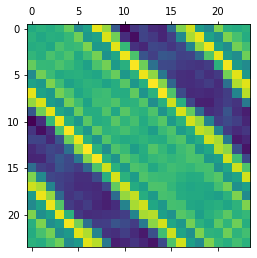

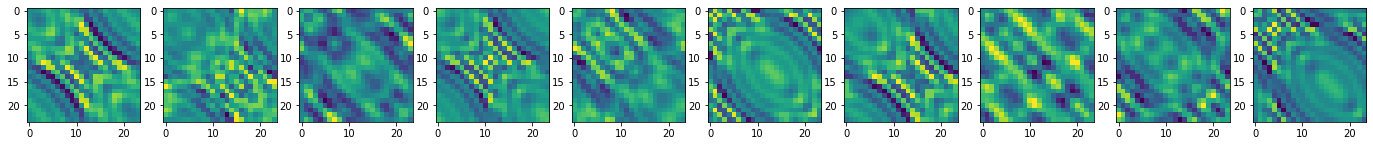

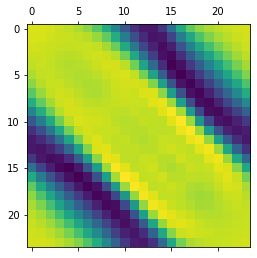

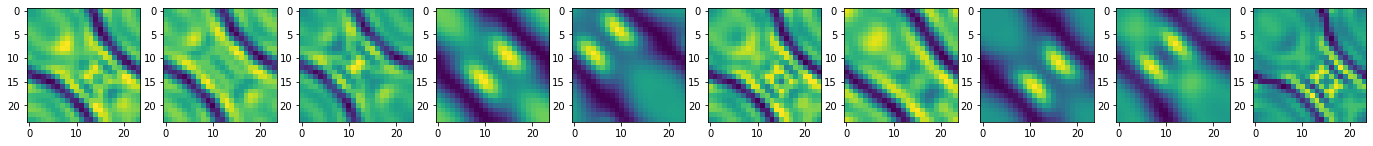

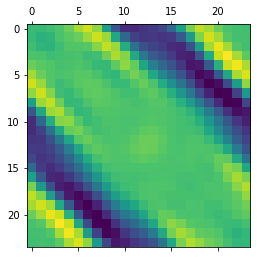

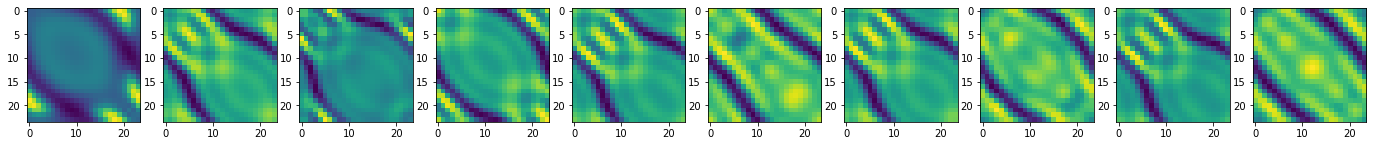

In [189]:
for i in range(0, len(cluster3_img)):   
    plt.matshow(centroids3[i])
    view_img(images = cluster3_img[i], row = 1, col = 10, size = 24,numImg=10)

View target image

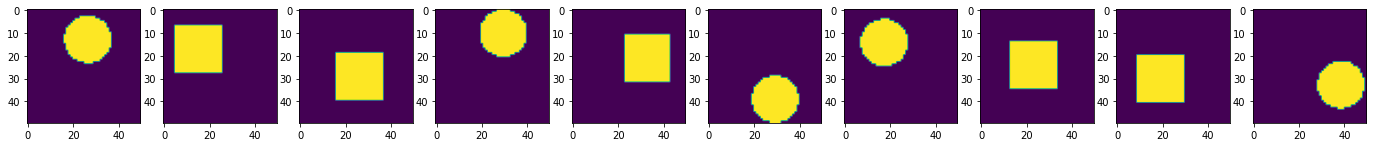

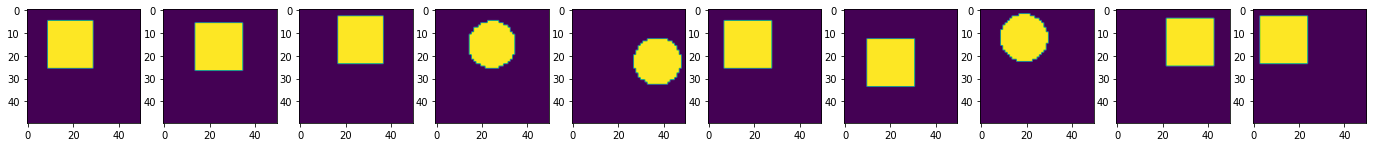

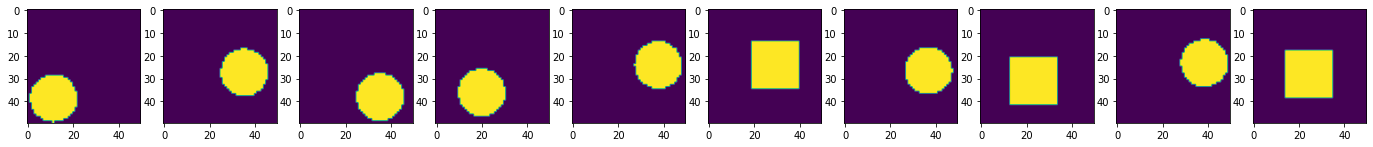

In [190]:
for i in range(0, len(cluster3_target)):   
    view_img(images=cluster3_target[i],row=1,col=10,size=24,numImg=10)

Try with 2 clusters corresponds to the 2 shapes

In [149]:
total_clusters = 2
kmeans2 = getKmeans(total_clusters, field_train)

In [150]:
centroids2 = kmeans2.cluster_centers_.reshape(total_clusters,24,24)
centroids2.shape

(2, 24, 24)

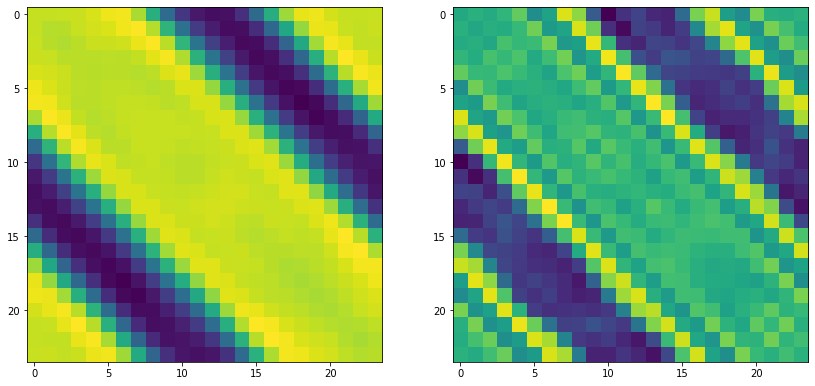

In [151]:
plt.figure(figsize = (14,14))
for index, img in enumerate(centroids2):
    plt.subplot(1,len(centroids2),index+1)
    plt.imshow(img)
    # plt.axis('off')

In [152]:
cluster2_img, cluster2_freq, cluster2_target, cluster2_shape = getClusters(kmeans2, field_train_CS, freq_train_CS, target_train_CS, 
                                                                           shape_train_CS, True, False, True, True)

Cluster 0 has 250 images, frequency = [1000000000.0, 2000000000.0]
Cluster 1 has 134 images, frequency = [2000000000.0, 3000000000.0]
Cluster 0 has shape(s)['Circ', 'Sqr']
Cluster 1 has shape(s)['Circ', 'Sqr']


In [153]:
percent_summary(0, cluster2_freq, cluster2_shape, True, True, True)

Cluster: 0
  shape          freq  Count  Percentage
0  Circ  1.000000e+09     64        25.6
1  Circ  2.000000e+09     58        23.2
2   Sqr  1.000000e+09     60        24.0
3   Sqr  2.000000e+09     68        27.2
           freq  Count  Percentage
0  1.000000e+09    124        49.6
1  2.000000e+09    126        50.4
  shape  Count  Percentage
0  Circ    122        48.8
1   Sqr    128        51.2


In [163]:
percent_summary(1, cluster2_freq, cluster2_shape, True, True, True)

Cluster: 1
  shape          freq  Count  Percentage
0  Circ  2.000000e+09      3    2.238806
1  Circ  3.000000e+09     68   50.746269
2   Sqr  2.000000e+09      1    0.746269
3   Sqr  3.000000e+09     62   46.268657
           freq  Count  Percentage
0  2.000000e+09      4    2.985075
1  3.000000e+09    130   97.014925
  shape  Count  Percentage
0  Circ     71   52.985075
1   Sqr     63   47.014925


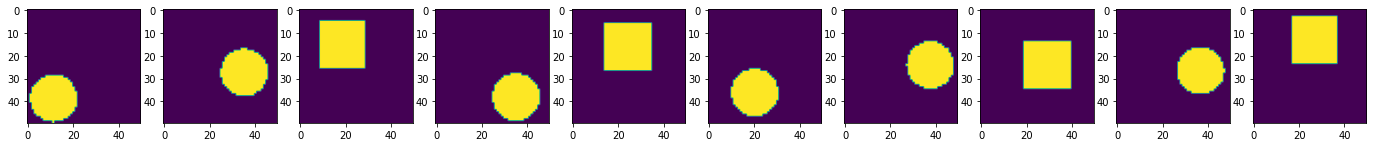

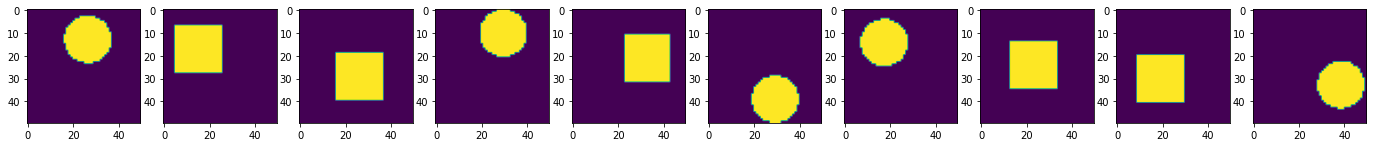

In [195]:
for i in range(0, len(cluster2_target)):   
    # plt.matshow(centroids[i])
    view_img(images=cluster2_target[i],row=1,col=10,size=24,numImg=10)

Evaluate our models

In [196]:
def getPrediction(field_test, Kmeans):
    predicted_cluster = Kmeans.predict(field_test)

    field_test_for_plot = {}
    labels = predicted_cluster
    test_img = []
    for i, label in enumerate(labels):
        if label not in field_test_for_plot:
            field_test_for_plot[label] = []
        field_test_for_plot[label].append(field_test[i].reshape(24,24,))  # Add the image to the corresponding cluster

    return field_test_for_plot, predicted_cluster

In [197]:
predImg3, predLabel3 = getPrediction(field_test, kmeans3)
predImg2, predLabel2 = getPrediction(field_test, kmeans2)

In [198]:
from sklearn.metrics import silhouette_score

silhouette_avg_3 = silhouette_score(field_test, predLabel3)
silhouette_avg_2 = silhouette_score(field_test, predLabel2)

[silhouette_avg_3,silhouette_avg_2]

[0.19241613782258757, 0.20683290439347415]

Evaluate other number of clusters

Text(0.5, 1.0, 'Elbow Plot for MiniBatchKmeans')

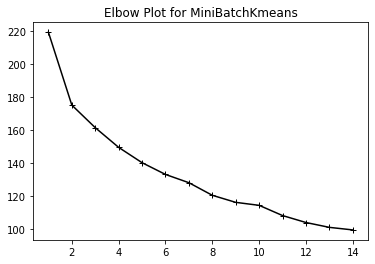

In [199]:
wcss = []
for i in range(1,15):
    minikmeans = getKmeans(num_clusters=i, train_data=field_train)
    wcss.append(minikmeans.inertia_)

plt.plot(range(1,15), wcss, marker = "+", c = "black")
plt.title("Elbow Plot for MiniBatchKmeans")

Maybe squares and circles are too similar to distinguish just from the field image?? 

Let's try this triangles and circles

In [135]:
fieldTri, targetTri, freqTri, shapeTri = readData("./TriangleDifFreq/", True)

Read 240 samples


In [136]:
fieldCT = np.concatenate((fieldCirc, fieldTri))
targetCT = np.concatenate((targetCirc, targetTri))
freqCT = np.concatenate((freqCirc, freqTri))
shapeCT = np.concatenate((shapeCirc, shapeTri))

In [137]:
field_train_CT, field_test_CT, target_train_CT, target_test_CT, freq_train_CT, freq_test_CT, shape_train_CT, shape_test_CT  = train_test_split(
    fieldCT, targetCT, freqCT, shapeCT, test_size=0.20, random_state=42)

In [138]:
field_test_CT = field_test_CT.reshape(len(field_test_CT),-1)

field_train_CT = field_train_CT.reshape(len(field_train_CT),-1)

[field_test_CT.shape, field_train_CT.shape]

[(96, 576), (384, 576)]

In [139]:
total_clusters = 3
kmeans3CT = getKmeans(total_clusters, field_train_CT)

In [140]:
centroids3CT = kmeans3CT.cluster_centers_.reshape(total_clusters,24,24)
centroids3CT.shape

(3, 24, 24)

Plot the centroids for the clusters

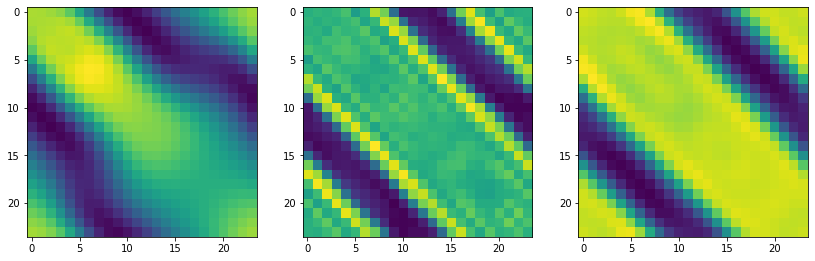

In [141]:
plt.figure(figsize = (14,14))
for index, img in enumerate(centroids3CT):
    plt.subplot(1,len(centroids3CT),index+1)
    plt.imshow(img)
    # plt.axis('off')

In [142]:
cluster3CT_img, cluster3CT_freq, cluster3CT_target, cluster3CT_shape = getClusters(kmeans3CT, field_train_CT, freq_train_CT, 
                                                                                   target_train_CT, shape_train_CT, True, False, 
                                                                                   True, True)

Cluster 0 has 53 images, frequency = [1000000000.0]
Cluster 1 has 199 images, frequency = [2000000000.0, 3000000000.0]
Cluster 2 has 132 images, frequency = [1000000000.0, 2000000000.0]
Cluster 0 has shape(s)['Triangle']
Cluster 1 has shape(s)['Circ', 'Triangle']
Cluster 2 has shape(s)['Circ', 'Triangle']


In [164]:
percent_summary(0, cluster3CT_freq, cluster3CT_shape, True)

Cluster: 0
      shape          freq  Count  Percentage
0  Triangle  1.000000e+09     53       100.0


In [165]:
percent_summary(1, cluster3CT_freq, cluster3CT_shape, True, True, True)

Cluster: 1
      shape          freq  Count  Percentage
0      Circ  2.000000e+09      3    1.507538
1      Circ  3.000000e+09     68   34.170854
2  Triangle  2.000000e+09     61   30.653266
3  Triangle  3.000000e+09     67   33.668342
           freq  Count  Percentage
0  2.000000e+09     64   32.160804
1  3.000000e+09    135   67.839196
      shape  Count  Percentage
0      Circ     71   35.678392
1  Triangle    128   64.321608


In [166]:
percent_summary(2, cluster3CT_freq, cluster3CT_shape, True, True, True)

Cluster: 2
      shape          freq  Count  Percentage
0      Circ  1.000000e+09     64   48.484848
1      Circ  2.000000e+09     58   43.939394
2  Triangle  1.000000e+09     10    7.575758
           freq  Count  Percentage
0  1.000000e+09     74   56.060606
1  2.000000e+09     58   43.939394
      shape  Count  Percentage
0      Circ    122   92.424242
1  Triangle     10    7.575758


Cluster 0 only contains frequency 1e9. Again, frequency 1e9 and 3e9 aren't in the same cluster

Seems like Cluster 0 with frequency 1e9 only has triangles

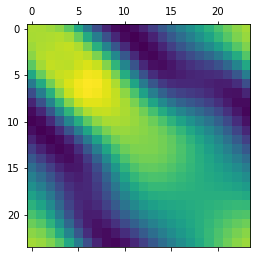

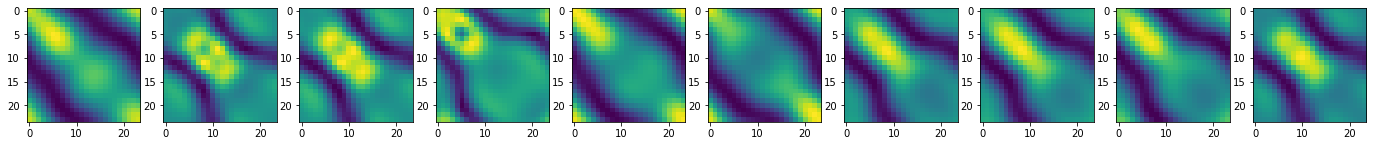

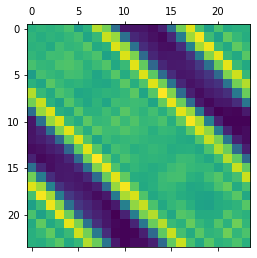

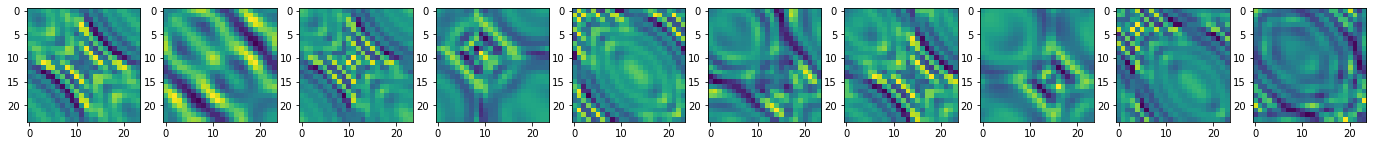

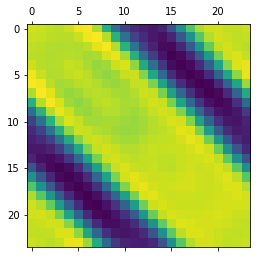

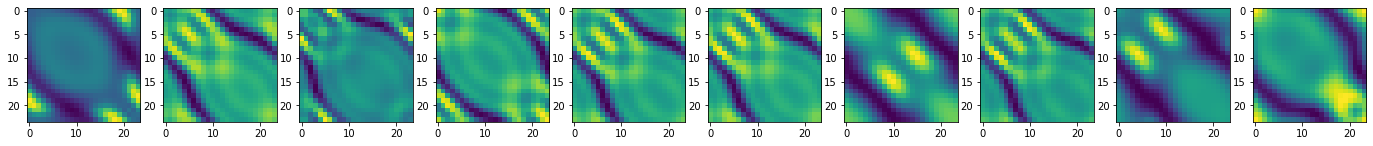

In [223]:
for i in range(0, len(cluster3CT_img)):   
    plt.matshow(centroids3CT[i])
    view_img(images = cluster3CT_img[i], row = 1, col = 10, size = 24, numImg = 10)

View target image

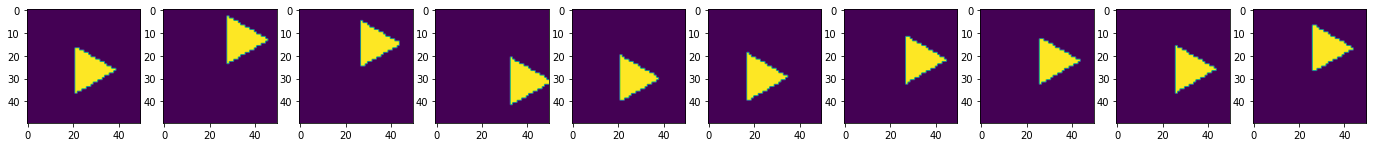

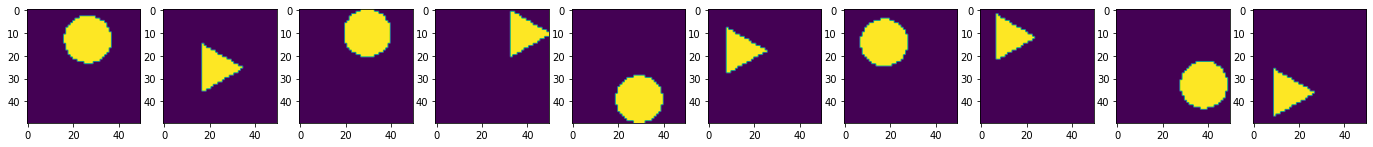

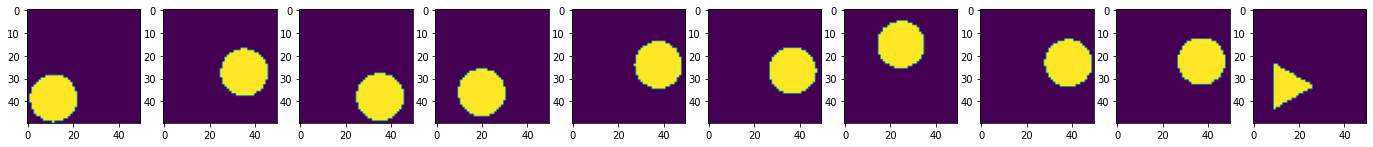

In [226]:
for i in range(0, len(cluster3CT_target)):   
    view_img(images=cluster3CT_target[i],row=1,col=10,size=24,numImg=10)

Try 2 clusters

In [167]:
total_clusters = 2
kmeans2CT = getKmeans(total_clusters, field_train_CT)

In [168]:
cluster2CT_img, cluster2CT_freq, cluster2CT_target, cluster2CT_shape = getClusters(kmeans2CT, field_train_CT, freq_train_CT, 
                                                                                   target_train_CT, shape_train_CT, True, False, 
                                                                                   True, True)

Cluster 0 has 72 images, frequency = [1000000000.0]
Cluster 1 has 312 images, frequency = [1000000000.0, 2000000000.0, 3000000000.0]
Cluster 0 has shape(s)['Circ', 'Triangle']
Cluster 1 has shape(s)['Circ', 'Triangle']


In [170]:
percent_summary(0, cluster2CT_freq, cluster2CT_shape, True, True, True)

Cluster: 0
      shape          freq  Count  Percentage
0      Circ  1.000000e+09      9        12.5
1  Triangle  1.000000e+09     63        87.5
           freq  Count  Percentage
0  1.000000e+09     72       100.0
      shape  Count  Percentage
0      Circ      9        12.5
1  Triangle     63        87.5


In [171]:
percent_summary(1, cluster2CT_freq, cluster2CT_shape, True, True, True)

Cluster: 1
      shape          freq  Count  Percentage
0      Circ  1.000000e+09     55   17.628205
1      Circ  2.000000e+09     61   19.551282
2      Circ  3.000000e+09     68   21.794872
3  Triangle  2.000000e+09     61   19.551282
4  Triangle  3.000000e+09     67   21.474359
           freq  Count  Percentage
0  1.000000e+09     55   17.628205
1  2.000000e+09    122   39.102564
2  3.000000e+09    135   43.269231
      shape  Count  Percentage
0      Circ    184   58.974359
1  Triangle    128   41.025641


Evaluate our models

In [229]:
predImg3CT, predLabel3CT = getPrediction(field_test_CT, kmeans3CT)
predImg2CT, predLabel2CT = getPrediction(field_test_CT, kmeans2CT)

In [230]:
from sklearn.metrics import silhouette_score

silhouette_avg_3CT = silhouette_score(field_test_CT, predLabel3CT)
silhouette_avg_2CT = silhouette_score(field_test_CT, predLabel2CT)

[silhouette_avg_3CT,silhouette_avg_2CT]

[0.18227026636394292, 0.3500564527421124]

Evaluate other number of clusters

Text(0.5, 1.0, 'Elbow Plot for MiniBatchKmeans')

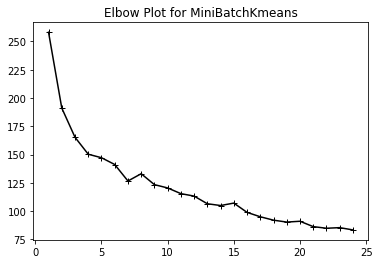

In [234]:
wcss = []
for i in range(1,25):
    minikmeans = getKmeans(num_clusters=i, train_data=field_train_CT)
    wcss.append(minikmeans.inertia_)

plt.plot(range(1,25), wcss, marker = "+", c = "black")
plt.title("Elbow Plot for MiniBatchKmeans")